## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
import html5lib
from bs4 import BeautifulSoup
import requests
import spacy
from nltk.tokenize import sent_tokenize

## Financial Analysis

In [48]:
def getSymbolReport(symbol:str) -> str:
    """
    Get required financial report for the desired symbol.
    symbol: Symbol
    """
    ticker = yf.Ticker(symbol)
    info_dict = ticker.get_info()
    news_list = ticker.get_news()
    institutional_holders = ticker.get_institutional_holders()
    mutualfund_holders = ticker.get_mutualfund_holders()   
    ann_income_stmt = ticker.get_income_stmt()
    qua_income_stmt = ticker.quarterly_income_stmt
    ann_balance_sheet = ticker.get_balance_sheet()
    qua_balance_sheet = ticker.quarterly_balance_sheet

    def getCompanyInfo(info_dict:dict) -> str: 

        sel_fields = ['longName','website','sector','industry','longBusinessSummary','fullTimeEmployees','companyOfficers']
        s = f"## **{info_dict['longName']}**<br>\n"
        for field in sel_fields:
            if field in info_dict.keys():
                if field == 'longBusinessSummary':
                    s += f"\n### **Business Summary**<br>\n{info_dict[field]}"
                    continue
                elif field == 'fullTimeEmployees':
                    s += "\n### **Employee Details**<br>\n"
                elif field == 'companyOfficers':
                    s += 'majorEmployees:<br>\n'
                    for officer in info_dict['companyOfficers']:
                        s += f"- {officer['name']}: {officer['title']}<br>\n"
                    continue
                s += f"{field}: " + str(info_dict[field]) + "<br>\n"
        return s
    
    def getCompanyNews(news_list:list) -> str:

        sel_fields = ['title','link','publisher']
        s = f"### **Recent Company News**<br>\n"
        for news in news_list:
            for field in sel_fields:
                s += f"{field}: " + f"{news[field]}<br>\n"
            s += "<br>\n"
        return s
    
    def getInvestorData(df1:pd.DataFrame, df2:pd.DataFrame) -> str:

        # Institutional Holders and Percentage Holding
        plt.figure(figsize=(15,5))
        plt.title(f'Institutional Holders and Percentage Holding - {symbol}')
        plt.pie(df1['Shares'],normalize=True,labels=df1['Holder'])
        plt.pie(df1['Shares'],normalize=True,labels=round((df1['Shares']/df1['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Institutional_Holders_and_Percentage_Holding.png')
        
        # Mutual_Fund_Holders_and_Percentage_Holding
        plt.figure(figsize=(15,5))
        plt.title(f'Mutual Fund Holders and Percentage Holding - {symbol}')
        plt.pie(df2['Shares'],normalize=True,labels=df2['Holder'])
        plt.pie(df2['Shares'],normalize=True,labels=round((df2['Shares']/df2['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png')

        s = "### **Investor Data**<br>\n![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>\n![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>\n"
        return s
    
    def plot_current_ratio(df1:dict, df4:pd.DataFrame, df5:pd.DataFrame, ann:bool, qua:bool):
        
        columns1 = [str(column)[:10] for column in df4.columns]
        columns2 = [str(column)[:10] for column in df5.columns]

        s = ''

        if ann and qua:
            fig,ax = plt.subplots(1,2, figsize=(15,8))
            fig.suptitle(f'Liquidity Ratio: Current Ratio - {symbol}')
            ax0t = ax[0].twiny()
            coords = np.arange(len(columns1))
            coords1 = coords + 0.125
            coords2 = coords - 0.125
            scaling_factor = 2/max(np.max([np.array(df4.loc['CurrentAssets']), np.array(df4.loc['CurrentLiabilities'])], axis = 0))
            ax0t.barh(coords1, np.array(df4.loc['CurrentAssets'])*scaling_factor,0.25 , color = 'g', alpha = 0.6)
            ax0t.barh(coords2, np.array(df4.loc['CurrentLiabilities'])*scaling_factor,0.25 , color = 'r', alpha = 0.6)
            ax0t.set_xlabel(f'Downscaled Current Assets and Liablities, Scaling Factor: {scaling_factor:.3e}')

            ax[0].set_title('Annual Current Ratio')
            ax[0].plot(np.array(df4.loc['CurrentAssets'])/np.array(df4.loc['CurrentLiabilities']), columns1)
            ax[0].set_ylabel('Time Instance')
            ax[0].set_xlabel('Current Ratio')
            ax[0].grid(alpha = 0.5)
            ax0t.legend(['Current Assets', 'Current Liabilities'], loc = 'upper right')

            ax1t = ax[1].twiny()
            coords = np.arange(len(columns2))
            coords1 = coords + 0.125
            coords2 = coords - 0.125
            scaling_factor = 2/max(np.max([np.array(df5.loc['Current Assets']), np.array(df5.loc['Current Liabilities'])], axis = 0))
            ax1t.barh(coords1, np.array(df5.loc['Current Assets'])*scaling_factor,0.25 , color = 'g', alpha = 0.6)
            ax1t.barh(coords2, np.array(df5.loc['Current Liabilities'])*scaling_factor,0.25 , color = 'r', alpha = 0.6)
            ax1t.set_xlabel(f'Downscaled Current Assets and Liablities, Scaling Factor: {scaling_factor:.3e}')
            ax1t.legend(['Current Assets', 'Current Liabilities'], loc = 'upper right')

        
            ax[1].set_title('Quarterly Current Ratio')
            ax[1].plot( np.array(df5.loc['Current Assets'])/np.array(df5.loc['Current Liabilities']), columns2)
            ax[1].set_xlabel('Current Ratio')
            ax[1].grid(alpha = 0.5)
            plt.savefig('./ReportMedia/Current_Ratio.png')

            s = "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
        elif ann:
            fig = plt.figure()
            plt.title(f'Annual Current Ratio - {symbol}')
            plt.plot(np.array(df4.loc['CurrentAssets'])/np.array(df4.loc['CurrentLiabilities']), columns1)
            plt.ylabel('Time Instance')
            plt.xlabel('Current Ratio')
            plt.grid()
            s = "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
        elif qua:
            fig = plt.figure()
            plt.title(f'Quarterly Current Ratio - {symbol}')
            plt.plot(np.array(df5.loc['CurrentAssets'])/np.array(df5.loc['CurrentLiabilities']), columns2)
            plt.ylabel('Time Instance')
            plt.xlabel('Current Ratio')
            plt.grid()
            s = "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
        else:
            s = f'Historical Data Unavailable. Recent Current Ratio of {symbol}: {df1['currentRatio']}<br>\n'
        return s
    
    # def plot_quick_ratio(df1:dict, df4:pd.DataFrame, df5:pd.DataFrame):
    #     fields = ['CurrentAssets', 'CurrentLiabilities','Inventory','PrepaidAssets','OtherCurrentAssets']
    #     fields1 = ['Current Assets', 'Current Liabilities','Inventory','Prepaid Assets','Other Current Assets']
    #     columns1 = [str(column)[:10] for column in df4.columns]
    #     columns2 = [str(column)[:10] for column in df5.columns]
    #     ann_quick_ratio = []
    #     qua_quick_ratio = []
    #     for index,i in enumerate(fields):
    #         if i in df4.index:
    #             ann_quick_ratio.append(index)
    #     for index,i in enumerate(fields1):
    #         if i in df5.index:
    #             qua_quick_ratio.append(index)
    #     s = ''

    #     if len(ann_quick_ratio) == 5  and len(qua_quick_ratio) == 5:
    #         fig,ax = plt.subplots(1,2,figsize=(15,8))
    #         fig.suptitle(f'Quick Ratio - {symbol}')
    #         ax[0].set_title('Annual Quick Ratio')
    #         ax[0].plot((np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['Inventory']) - np.array(df4.loc['PrepaidAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']), columns1)
    #         ax[0].set_ylabel('Time Instance')
    #         ax[0].set_xlabel('Quick Ratio')
    #         ax[0].grid(alpha = 0.5)

    #         ax[1].set_xticklabels(rotation=45, labels=df5.columns[:10])
    #         ax[1].set_title('Quarterly Quick Ratio')
    #         ax[1].plot( (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Inventory']) - np.array(df5.loc['Prepaid Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']), columns2)
    #         ax[1].set_xlabel('Quick Ratio')
    #         ax[1].grid(alpha = 0.5)

    #         plt.savefig('./ReportMedia/Quick_Ratio.png')
    #         s = "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"

    #     elif ([i in ann_quick_ratio for i in [0,1,2,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,2,4]] == 4*[True]):
    #         fig,ax = plt.subplots(1,2, figsize=(15,8))

    #         fig.suptitle(f'Quick Ratio - {symbol}')
    #         ax[0].set_title('Annual Quick Ratio')
    #         ax[0].plot((np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['Inventory']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']), columns1)
    #         ax[0].set_ylabel('Time Instance')
    #         ax[0].set_xlabel('Quick Ratio')
    #         ax[0].grid(alpha = 0.5)

            
    #         ax[1].set_title('Quarterly Quick Ratio')
    #         ax[1].plot((np.array(df5.loc['Current Assets']) - np.array(df5.loc['Inventory']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']), columns2)
    #         ax[1].set_xlabel('Quick Ratio')
    #         ax[1].grid(alpha = 0.5)

    #         plt.savefig('./ReportMedia/Quick_Ratio.png')
    #         s = "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"
        
    #     elif ([i in ann_quick_ratio for i in [0,1,3,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,3,4]] == 4*[True]):
    #         fig,ax = plt.subplots(1,2, figsize=(15,8))
    #         fig.suptitle(f'Quick Ratio - {symbol}')
            
    #         ax[0].set_title('Annual Quick Ratio')
    #         ax[0].plot((np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['PrepaidAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']), columns1)
    #         ax[0].set_ylabel('Time Instance')
    #         ax[0].set_xlabel('Quick Ratio')
    #         ax[0].grid(alpha = 0.5)


    #         ax[1].set_title('Quarterly Quick Ratio')
    #         ax[1].plot((np.array(df5.loc['Current Assets']) - np.array(df5.loc['Prepaid Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']), columns2)
    #         ax[1].set_xlabel('Quick Ratio')
    #         ax[1].grid(alpha = 0.5)

    #         plt.savefig('./ReportMedia/Quick_Ratio.png')
    #         s = "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"

    #     elif ([i in ann_quick_ratio for i in [0,1,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,4]] == 4*[True]):
    #         fig,ax = plt.subplots(1,2, figsize=(15,8))
    #         fig.suptitle(f'Quick Ratio - {symbol}')
            
    #         ax[0].set_title('Annual Quick Ratio')
    #         ax[0].plot((np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']), columns1)
    #         ax[0].set_ylabel('Time Instance')
    #         ax[0].set_xlabel('Quick Ratio')
    #         ax[0].grid(alpha = 0.5)

    #         ax[1].set_title('Quarterly Quick Ratio')
    #         ax[1].plot((np.array(df5.loc['Current Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']), columns2)
    #         ax[1].set_xlabel('Quick Ratio')
    #         ax[1].grid(alpha = 0.5)

    #         plt.savefig('./ReportMedia/Quick_Ratio.png')
    #         s = "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"
        
    #     else:
    #         s = f'Historical Data Unavailable. Recent Quick Ratio for {symbol}: {df1['quickRatio']}<br>\n'
    #     return s
    
    def plot_general_financials(df1:dict, df2:pd.DataFrame, df3:pd.DataFrame, df4:pd.DataFrame, df5:pd.DataFrame):
        fig,ax = plt.subplots(1,2, figsize=(15,8))
        fig.suptitle(f'General Financials - {symbol}\nMarket Cap: \${df1['marketCap']:,} | Enterprise Value: \${df1["enterpriseValue"]:,}')
        
        columns1 = [str(column)[:10] for column in df2.columns]
        columns2 = [str(column)[:10] for column in df3.columns]

        ax[0].set_title(f'Annual Total Revenue, Income, Expenses and Debt')
        ax[0].barh(np.arange(len(df2.columns))+0.3, df2.loc['TotalRevenue'], 0.2 , color = 'g', alpha = 0.6)
        ax[0].barh(np.arange(len(df2.columns))+0.1, df2.loc['NetIncome'], 0.2 , color = 'violet', alpha = 0.6)
        ax[0].barh(np.arange(len(df2.columns))-0.1, df2.loc['TotalExpenses'], 0.2 , color = 'r', alpha = 0.6)
        ax[0].barh(np.arange(len(df2.columns))-0.3, df4.loc['TotalDebt'], 0.2 , color = 'orange', alpha = 0.6)
        ax[0].grid(alpha = 0.5)
        ax[0].set_xlabel('Amount')
        ax[0].set_ylabel('Time Instance')
        ax[0].set_yticks(np.arange(len(df2.columns)))
        ax[0].set_yticklabels(columns1)
        ax[0].legend(['Total Revenue', 'Net Income', 'Total Expenses', 'Total Debt'])


        ax[1].set_title(f'Quarterly Total Revenue, Income, Expenses and Debt')
        ax[1].barh(np.arange(len(df3.columns))+0.3, df3.loc['Total Revenue'], 0.2 , color = 'g', alpha = 0.6)
        ax[1].barh(np.arange(len(df3.columns))+0.1, df3.loc['Net Income'], 0.2 , color = 'violet', alpha = 0.6)
        ax[1].barh(np.arange(len(df3.columns))-0.1, df3.loc['Total Expenses'], 0.2 , color = 'r', alpha = 0.6)
        ax[1].barh(np.arange(len(df3.columns))-0.3, df5.loc['Total Debt'], 0.2 , color = 'orange', alpha = 0.6)
        ax[1].grid(alpha = 0.5)
        ax[1].set_xlabel('Amount')
        ax[1].set_yticks(np.arange(len(df3.columns)))
        ax[1].set_yticklabels(columns2)
        ax[1].legend(['Total Revenue', 'Net Income', 'Total Expenses', 'Total Debt'])
        plt.savefig('./ReportMedia/General_Financials.png')
        return '![General Financials](./ReportMedia/General_Financials.png)<br>\n'

    def plot_solvency_ratios(df4:pd.DataFrame, df5:pd.DataFrame):
        fig, ax = plt.subplots(1,2, figsize = (15, 8))
        fig.suptitle(f'Solvency Ratios - {symbol}')
        columns1 = [str(column)[:10] for column in df4.columns[::-1]]
        columns2 = [str(column)[:10] for column in df5.columns[::-1]]

        ax[0].set_title('Annual Solvency Ratios')
        ax[0].plot(np.arange(len(columns1)), np.array(df4.loc['TotalDebt'][::-1])/np.array(df4.loc['TotalAssets'][::-1]), color = 'g', marker = 'o', alpha = 0.7)
        ax[0].plot(np.arange(len(columns1)), np.array(df4.loc['TotalDebt'][::-1])/np.array(df4.loc['StockholdersEquity'][::-1]), 'ro-', alpha = 0.7)
        ax[0].plot(np.arange(len(columns1)), np.array(df4.loc['StockholdersEquity'][::-1])/np.array(df4.loc['TotalAssets'][::-1]), color = 'orange', marker = 'o', alpha = 0.7)
        ax[0].grid(alpha = 0.5)
        ax[0].legend(['Debt-to-Asset Ratio', 'Debt-to-Equity Ratio', 'Shareholder Equity Ratio'])
        ax[0].set_xlabel('Time Instance')
        ax[0].set_ylabel('Ratio')
        ax[0].set_xticks(np.arange(len(columns1)))
        ax[0].set_xticklabels(columns1)

        ax[1].set_title('Quarterly Solvency Ratios')
        ax[1].plot(np.arange(len(columns2)), np.array(df5.loc['Total Debt'][::-1])/np.array(df5.loc['Total Assets'][::-1]), color = 'g', marker = 'o', alpha = 0.7)
        ax[1].plot(np.arange(len(columns2)), np.array(df5.loc['Total Debt'][::-1])/np.array(df5.loc['Stockholders Equity'][::-1]), 'ro-', alpha = 0.7)
        ax[1].plot(np.arange(len(columns2)), np.array(df5.loc['Stockholders Equity'][::-1])/np.array(df5.loc['Total Assets'][::-1]), color = 'orange', marker = 'o', alpha = 0.7)
        ax[1].grid(alpha = 0.5)
        ax[1].legend(['Debt-to-Asset Ratio', 'Debt-to-Equity Ratio', 'Shareholder Equity Ratio'])
        ax[1].set_xlabel('Time Instance')
        ax[1].set_xticks(np.arange(len(columns2)))
        ax[1].set_xticklabels(columns2)
        plt.savefig('./ReportMedia/Solvency_Ratios.png')
        return '![Solvency Ratios](./ReportMedia/Solvency_Ratios.png)<br>\n'

    def plot_profitability_ratios(df2:pd.DataFrame, df3:pd.DataFrame, df4:pd.DataFrame, df5:pd.DataFrame):
        fig, ax = plt.subplots(1,2, figsize = (15, 8))
        fig.suptitle(f'Profitability Ratios - {symbol}')
        columns1 = [str(column)[:10] for column in df2.columns[::-1]]
        columns2 = [str(column)[:10] for column in df3.columns[::-1]]

        ax[0].set_title('Annual Profitability Ratios')
        ax[0].plot(np.arange(len(columns1)), np.array(df2.loc['NetIncome'][::-1])/np.array(df2.loc['TotalRevenue'][::-1]), color = 'g', marker = 'o', alpha = 0.7)
        ax[0].plot(np.arange(len(columns1)), np.array(df2.loc['NetIncome'][::-1])/np.array(df4.loc['TotalAssets'][::-1]), 'ro-', alpha = 0.7)
        ax[0].plot(np.arange(len(columns1)), np.array(df2.loc['NetIncome'][::-1])/np.array(df4.loc['StockholdersEquity'][::-1]), color = 'orange', marker = 'o', alpha = 0.7)
        ax[0].grid(alpha = 0.5)
        ax[0].legend(['Net Profit Margin', 'Return On Assets (ROA)', 'Return On Equity (ROE)'])
        ax[0].set_xlabel('Time Instance')
        ax[0].set_ylabel('Ratio')
        ax[0].set_xticks(np.arange(len(columns1)))
        ax[0].set_xticklabels(columns1)

        ax[1].set_title('Quarterly Profitability Ratios')
        ax[1].plot(np.arange(len(columns2)), np.array(df3.loc['Net Income'][::-1])/np.array(df3.loc['Total Revenue'][::-1]), color = 'g', marker = 'o', alpha = 0.7)
        ax[1].plot(np.arange(len(columns2)), np.array(df3.loc['Net Income'][::-1])/np.array(df5.loc['Total Assets'][::-1]), 'ro-', alpha = 0.7)
        ax[1].plot(np.arange(len(columns2)), np.array(df3.loc['Net Income'][::-1])/np.array(df5.loc['Stockholders Equity'][::-1]), color = 'orange', marker = 'o', alpha = 0.7)
        ax[1].grid(alpha = 0.5)
        ax[1].legend(['Net Profit Margin', 'Return On Assets (ROA)', 'Return On Equity (ROE)'])
        ax[1].set_xlabel('Time Instance')
        ax[1].set_xticks(np.arange(len(columns2)))
        ax[1].set_xticklabels(columns2)
        plt.savefig('./ReportMedia/Profitability_Ratios.png')
        return '![Profitability Ratios](./ReportMedia/Solvency_Ratios.png)<br>\n'
    
    def plot_earnings(df2:pd.DataFrame, df3:pd.DataFrame, df4:pd.DataFrame, df5:pd.DataFrame):
        fig, ax = plt.subplots(1,2, figsize = (15,8))
        fig.suptitle(f'Earnings - {symbol}')
        columns1 = [str(column)[:10] for column in df2.columns[::-1]]
        columns2 = [str(column)[:10] for column in df3.columns[::-1]]

        ax[0].set_title('Annual Earnings')
        ax[0].bar(np.arange(len(columns1)) - 0.125, np.array(df2.loc['EBITDA'][::-1]),0.4, color = 'g', alpha = 0.7)
        ax[0].bar(np.arange(len(columns1)) + 0.125, np.array(df2.loc['EBIT'][::-1]),0.4, color = 'violet', alpha = 0.7)
        ax[0].plot(np.arange(len(columns1)), np.array(df2.loc['BasicEPS'][::-1]), color = 'orange', marker = 'o', alpha = 0.7)
        ax[0].grid(alpha = 0.5)
        ax[0].legend(['Basic EPS','EBITDA', 'EBIT'])
        ax[0].set_xlabel('Time Instance')
        ax[0].set_ylabel('Amount')
        ax[0].set_xticks(np.arange(len(columns1)))
        ax[0].set_xticklabels(columns1)

        ax[1].set_title('Quarterly Earnings')
        ax[1].bar(np.arange(len(columns2)) - 0.125, np.array(df3.loc['EBITDA'][::-1]),0.4, color = 'g', alpha = 0.7)
        ax[1].bar(np.arange(len(columns2)) + 0.125, np.array(df3.loc['EBIT'][::-1]),0.4, color = 'violet', alpha = 0.7)
        ax[1].plot(np.arange(len(columns2)), np.array(df3.loc['Basic EPS'][::-1]), color = 'orange', marker = 'o', alpha = 0.7)
        ax[1].grid(alpha = 0.5)
        ax[1].legend(['Basic EPS','EBITDA', 'EBIT'])
        ax[1].set_xlabel('Time Instance')
        ax[1].set_xticks(np.arange(len(columns2)))
        ax[1].set_xticklabels(columns2)
        plt.savefig('./ReportMedia/Earnings.png')
        return '![Earnings](./ReportMedia/Earnings.png)<br>\n'


    def getFinancials(df1:dict, df2:pd.DataFrame, df3:pd.DataFrame, df4:pd.DataFrame, df5:pd.DataFrame):
        sel_fields = ['totalRevenue','totalDebt','netIncome', 'totalExpense','enterpriseValue','marketCap',
                       'currentRatio', # 'quickRatio',
                       'debtToEquity', 'debtToAssets', 'equityRatio',
                       'netProfitMargin','returnOnAssets','returnOnEquity',
                       'EBITDA','EBIT', 'BasicEPS']
        s = '### **Latest Financials**<br>\n#### General Financials<br>\n'
        for field in sel_fields:
            if field == 'currentRatio':
                s += '#### Liquidity Ratios<br>\n'
                ann_current_ratio = 0
                qua_current_ratio = 0
                if 'CurrentAssets' in df4.index and 'CurrentLiabilities' in df4.index:
                    ann_current_ratio = 1                    
                if 'Current Assets' in df5.index and 'Current Liabilities' in df5.index:
                    qua_current_ratio = 1
                
                s += plot_current_ratio(df1, df4, df5, ann_current_ratio, qua_current_ratio)
            # elif field == 'quickRatio':
            #     s += plot_quick_ratio(df1, df4, df5)
            elif field == 'totalRevenue':
                s += plot_general_financials(df1, df2, df3, df4, df5)
            elif field == 'debtToEquity':
                s += '#### Solvency Ratios<br>\n'
                s += plot_solvency_ratios(df4, df5)
            elif field == 'netProfitMargin':
                s += '#### Profitability Ratios<br>\n'
                s += plot_profitability_ratios(df2, df3, df4, df5)
            elif field == 'EBITDA':
                s += '#### Earnings'
                s += plot_earnings(df2, df3, df4, df5)
        return s

    # def plotStockData(ticker:str):

    #     data = yf.download(ticker,interval='1d')
    #     data = data.reset_index()
    #     start = data['Date'][0]
    #     step = 120
    #     dates = [str(d)[:10] for d in data['Date'][::step]]
    #     bench = yf.download('^GSPC', interval = '1d', start = start)
    #     bench = bench.reset_index()
    #     combined = pd.DataFrame({f'{ticker}':data['Adj Close'], 'S&P500': bench['Adj Close']})
    #     fig = plt.figure(figsize=(15,8))
    #     plt.title(f'{symbol} Stock Performance, Period = Max, Interval = 1d')
    #     plt.plot(combined[symbol], 'g')
    #     # plt.plot(combined['S&P500'], 'b')
    #     plt.xticks(np.arange(len(combined), step = step) ,labels = dates, rotation = 90)
    #     plt.legend([f'{ticker}'])
    #     plt.savefig('./ReportMedia/Stock_Chart.png')
        
    #     s = '### Technical Information<br>\n![Stock Chart](./ReportMedia/Stock_Chart.png)'
        return s
        
    return getCompanyInfo(info_dict = info_dict) + getCompanyNews(news_list = news_list) + getInvestorData(df1 = institutional_holders, df2 = mutualfund_holders) + getFinancials(df1 = info_dict, df2 = ann_income_stmt, df3 = qua_income_stmt, df4 = ann_balance_sheet, df5 = qua_balance_sheet)

<>:223: SyntaxWarning: invalid escape sequence '\$'
<>:223: SyntaxWarning: invalid escape sequence '\$'
<>:223: SyntaxWarning: invalid escape sequence '\$'
<>:223: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Hrriday\AppData\Local\Temp\ipykernel_22472\240568491.py:223: SyntaxWarning: invalid escape sequence '\$'
  fig.suptitle(f'General Financials - {symbol}\nMarket Cap: \${df1['marketCap']:,} | Enterprise Value: \${df1["enterpriseValue"]:,}')
C:\Users\Hrriday\AppData\Local\Temp\ipykernel_22472\240568491.py:223: SyntaxWarning: invalid escape sequence '\$'
  fig.suptitle(f'General Financials - {symbol}\nMarket Cap: \${df1['marketCap']:,} | Enterprise Value: \${df1["enterpriseValue"]:,}')


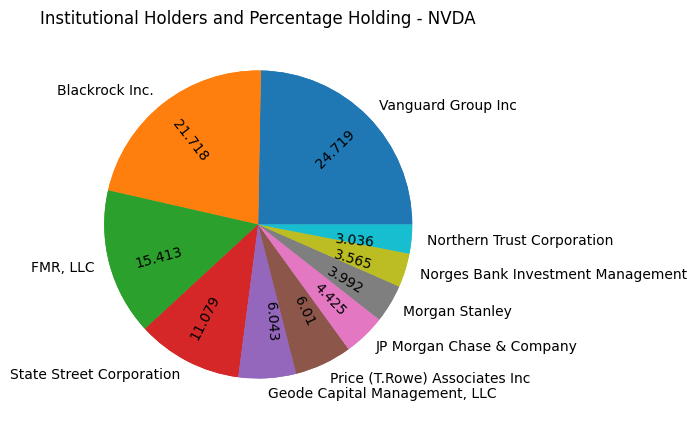

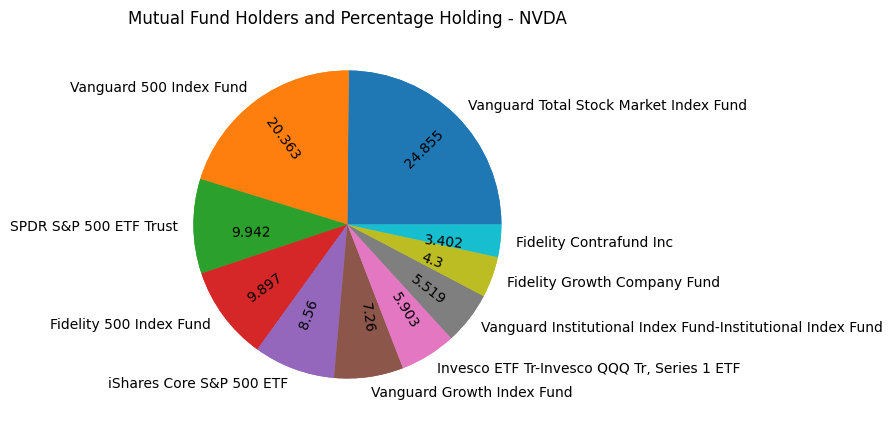

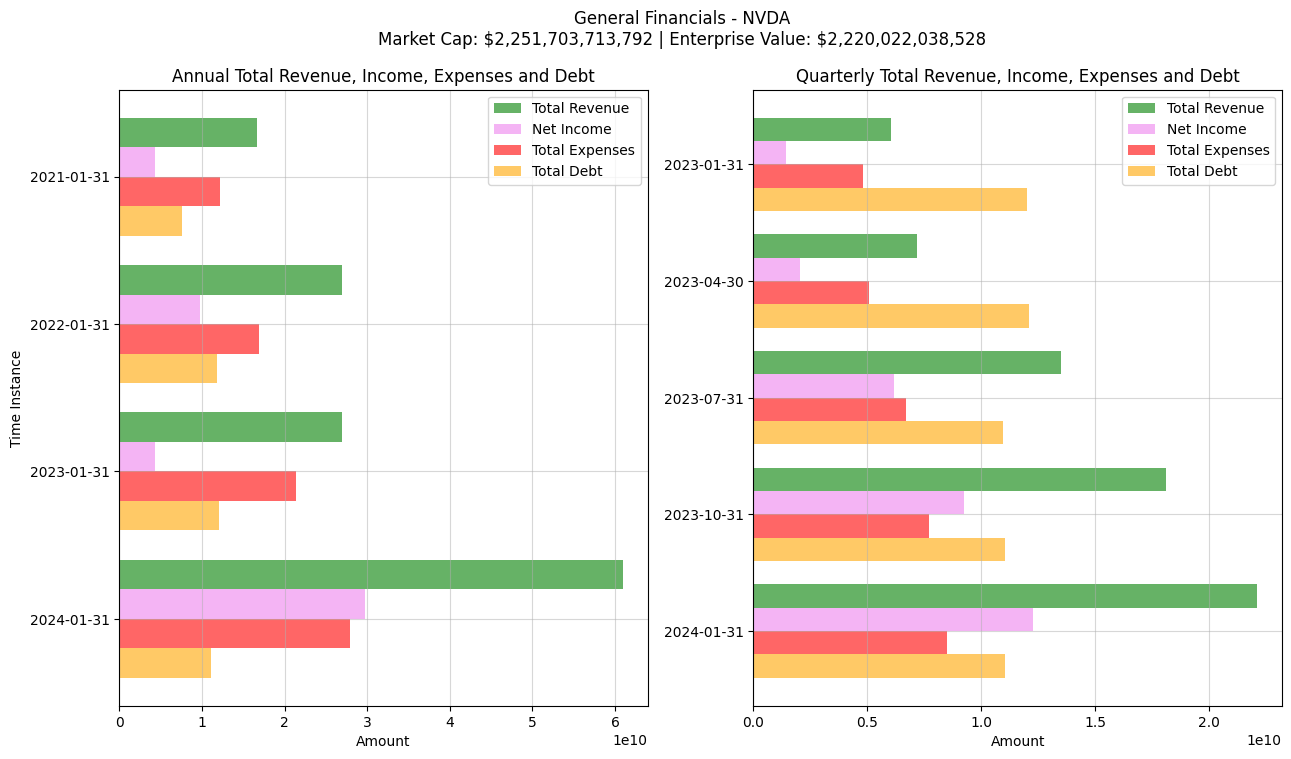

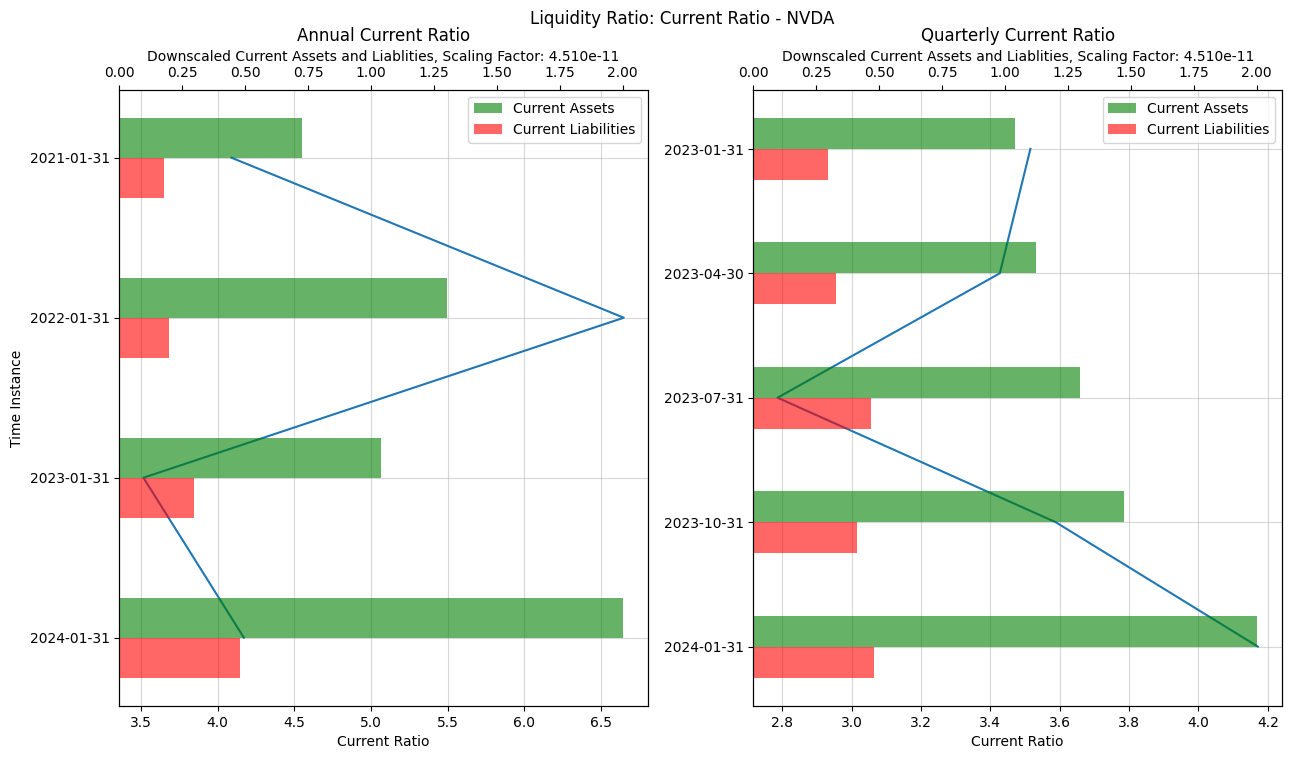

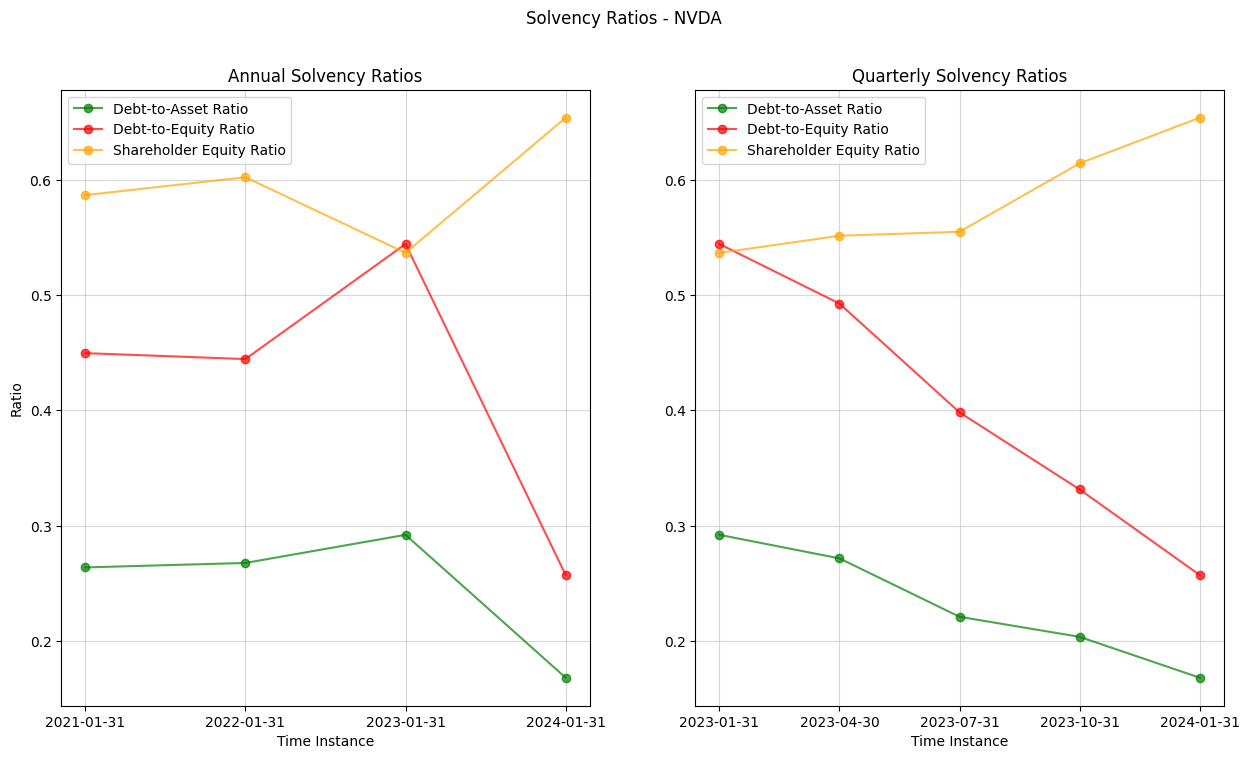

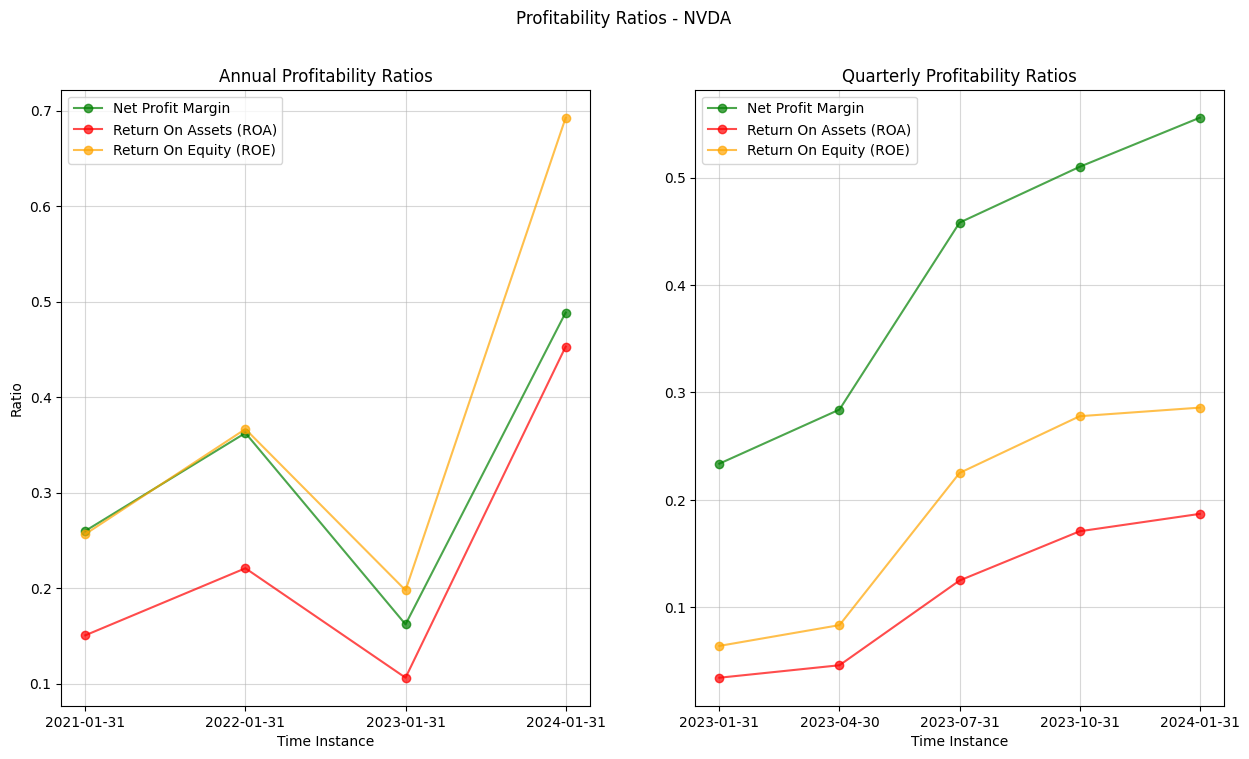

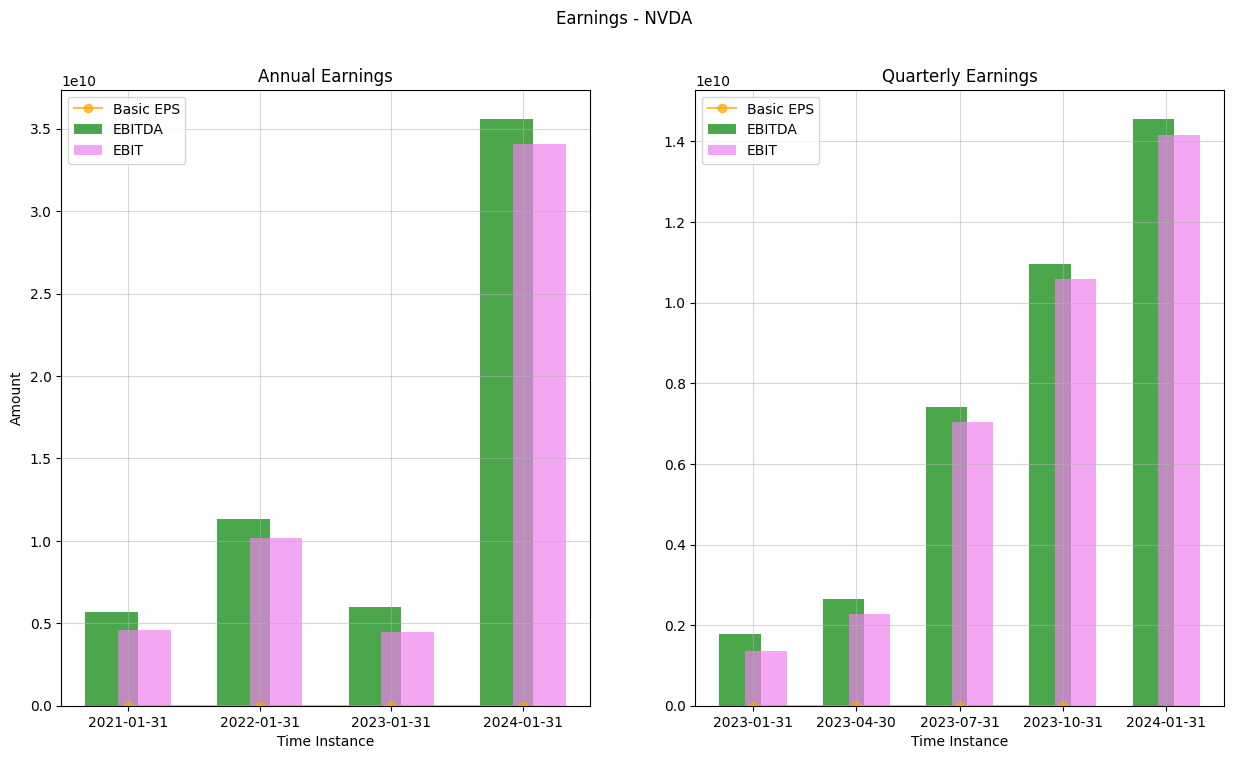

In [49]:
symbol = 'NVDA'
with open('Report.md','w') as file:
    file.write(getSymbolReport(symbol = symbol))
file.close()

## **NVIDIA Corporation**<br>
longName: NVIDIA Corporation<br>
website: https://www.nvidia.com<br>
sector: Technology<br>
industry: Semiconductors<br>

### **Business Summary**<br>
NVIDIA Corporation provides graphics, and compute and networking solutions in the United States, Taiwan, China, Hong Kong, and internationally. The Graphics segment offers GeForce GPUs for gaming and PCs, the GeForce NOW game streaming service and related infrastructure, and solutions for gaming platforms; Quadro/NVIDIA RTX GPUs for enterprise workstation graphics; virtual GPU or vGPU software for cloud-based visual and virtual computing; automotive platforms for infotainment systems; and Omniverse software for building and operating metaverse and 3D internet applications. The Compute & Networking segment comprises Data Center computing platforms and end-to-end networking platforms, including Quantum for InfiniBand and Spectrum for Ethernet; NVIDIA DRIVE automated-driving platform and automotive development agreements; Jetson robotics and other embedded platforms; NVIDIA AI Enterprise and other software; and DGX Cloud software and services. The company's products are used in gaming, professional visualization, data center, and automotive markets. It sells its products to original equipment manufacturers, original device manufacturers, system integrators and distributors, independent software vendors, cloud service providers, consumer internet companies, add-in board manufacturers, distributors, automotive manufacturers and tier-1 automotive suppliers, and other ecosystem participants. NVIDIA Corporation was incorporated in 1993 and is headquartered in Santa Clara, California.
### **Employee Details**<br>
fullTimeEmployees: 29600<br>
majorEmployees:<br>
- Mr. Jen-Hsun  Huang: Co-Founder, CEO, President & Director<br>
- Ms. Colette M. Kress: Executive VP & CFO<br>
- Ms. Debora  Shoquist: Executive Vice President of Operations<br>
- Mr. Timothy S. Teter: Executive VP, General Counsel & Secretary<br>
- Mr. Ajay K. Puri: Executive Vice President of Worldwide Field Operations<br>
- Mr. Chris A. Malachowsky: Co-Founder<br>
- Mr. Donald F. Robertson Jr.: VP & Chief Accounting Officer<br>
- Prof. William J. Dally: Chief Scientist & Senior VP of Research<br>
- Ms. Simona  Jankowski C.F.A., J.D.: Vice President of Investor Relations<br>
- Mr. Robert  Sherbin: Vice President of Corporate Communications<br>
### **Recent Company News**<br>
title: Dow Jones Futures: Nvidia Rises, Super Micro Prices Offering; Here Comes Fed's Earnings Report For Market<br>
link: https://finance.yahoo.com/m/ba55dbe6-8c4a-37e5-aa1d-2dd2d673cf98/dow-jones-futures%3A-nvidia.html<br>
publisher: Investor's Business Daily<br>
<br>
title: Samsung Jumps Most in Six Months After Nvidia CEO�s Backing<br>
link: https://finance.yahoo.com/news/samsung-jumps-most-six-months-041410501.html<br>
publisher: Bloomberg<br>
<br>
title: Analyst unveils Nvidia stock price 'line in the sand'<br>
link: https://finance.yahoo.com/m/8bad50c6-3cdf-3840-a3e8-99b21fce4222/analyst-unveils-nvidia-stock.html<br>
publisher: TheStreet<br>
<br>
title: Nvidia's Jensen Huang says AI hallucinations are solvable, artificial general intelligence is 5 years away<br>
link: https://finance.yahoo.com/m/c06a0a4e-5b9d-3aef-bc9d-d480ea845272/nvidia%27s-jensen-huang-says-ai.html<br>
publisher: TechCrunch<br>
<br>
title: Nvidia's keynote at GTC held some surprises<br>
link: https://finance.yahoo.com/m/52f5152f-a89d-3420-9c7b-e5803b105e14/nvidia%27s-keynote-at-gtc-held.html<br>
publisher: TechCrunch<br>
<br>
title: Nvidia CEO wants enterprise to think 'AI factory,' not data center<br>
link: https://finance.yahoo.com/m/3d366f39-6970-3b9a-95f0-9f06a4bd47af/nvidia-ceo-wants-enterprise.html<br>
publisher: TechCrunch<br>
<br>
title: Factbox-Key takeaways from Nvidia's annual developer conference<br>
link: https://finance.yahoo.com/news/factbox-key-takeaways-nvidias-annual-230031859.html<br>
publisher: Reuters<br>
<br>
title: Who's Afraid of the Fed's New Dot-Plot?<br>
link: https://finance.yahoo.com/news/whos-afraid-feds-dot-plot-220000851.html<br>
publisher: Zacks<br>
<br>
### **Investor Data**<br>
![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>
![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>
### **Latest Financials**<br>
#### General Financials<br>
![General Financials](./ReportMedia/General_Financials.png)<br>
#### Liquidity Ratios<br>
![Current Ratio](./ReportMedia/Current_Ratio.png)<br>
![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>
#### Solvency Ratios<br>
![Solvency Ratios](./ReportMedia/Solvency_Ratios.png)<br>


## Technical Analysis

In [4]:
symbol = 'NVDA'
data = yf.download(symbol, period='10y', interval='1d')
data = data.reset_index()

[*********************100%%**********************]  1 of 1 completed


In [5]:
ticker = yf.Ticker(symbol)
actions = ticker.actions
actions = actions.reset_index()

data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d")
dd = data['Date'][0]
for i in range(len(actions)):
    if actions.iloc[i,0].date() > dd.date():
        index = i
        break
    else:
        index = -1
actions = actions.iloc[index:, :]

In [6]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

period = 200
sim_mov_avg = data['Close'].rolling(window=period).mean()

candle_trace = go.Candlestick(
    x=data["Date"],
    open=data["Open"],
    high=data["High"],
    low=data["Low"],
    close=data["Close"],
    name = 'Price'
) 

mov_avg_trace = go.Scatter(
    x=data['Date'],
    y= sim_mov_avg,
    line=dict(color="orange"),
    name=f"MA{period}"
)

volume_trace = go.Bar(
    x=data["Date"],
    y=data['Volume'],
    name='Volume',
    marker=dict(color='white'),
    opacity=1,  
    showlegend=True
)

fig.add_trace(candle_trace, row = 1, col = 1)
fig.add_trace(mov_avg_trace, row = 1, col = 1)
fig.add_trace(volume_trace, row = 2, col = 1)


fig.update_layout(
    xaxis_rangeslider_visible = False,
    template = 'plotly_dark',
    title= f"{symbol} Chart",
    xaxis_title="Date",
    yaxis_title= f"Stock Price",
    width=2000,
    height=1500
)

for i in range(len(actions)):
    if actions.iloc[i, 2] != 0:
        date = actions.iloc[i, 0].date()
        fig.add_vline(x=date, line_width=1, line_color="green", line_dash="solid", row = 'all', col = 'all')

for i in range(len(actions)):
    if actions.iloc[i, 1] != 0:
        date = actions.iloc[i, 0].date()
        fig.add_vline(x=date, line_width=1, line_color="yellow", line_dash='dash', row = 'all', col = 'all', opacity=0.4)


fig.show()

## Web Scraping

Credits: Nicholas Abell<br>
Reference: https://medium.com/@nqabell89/scraping-the-s-p-500-from-wikipedia-with-pandas-beautiful-soup-ba22101cb5ed

In [7]:
# Scrape the entire S&P500 list from Wikipedia into a Pandas DataFrame;
ticker_list = pd.read_html(
'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = ticker_list[0]

In [8]:
df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [9]:
# Use BeautifulSoup to scrape individual wikipedia page urls for each ticker;
request = requests.get(
'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df['WIKI_URL'] = ''
soup = BeautifulSoup(request.content)
main_table = soup.find(id='constituents')
table = main_table.find('tbody').findAll('tr')
table = table[1:]
base_url = 'https://en.wikipedia.org'
url_list = []
for item in table:
    url = base_url + str(item.findAll('a')[1]['href'])
    url_list.append(url)
    
df['WIKI_URL'] = url_list

In [10]:
df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,WIKI_URL
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902,https://en.wikipedia.org/wiki/3M
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,https://en.wikipedia.org/wiki/A._O._Smith
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888,https://en.wikipedia.org/wiki/Abbott_Laboratories
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),https://en.wikipedia.org/wiki/AbbVie
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,https://en.wikipedia.org/wiki/Accenture
...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,https://en.wikipedia.org/wiki/Yum!_Brands
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,https://en.wikipedia.org/wiki/Zebra_Technologies
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,https://en.wikipedia.org/wiki/Zimmer_Biomet
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873,https://en.wikipedia.org/wiki/Zions_Bancorpora...


In [12]:
url = df[df['Symbol'] == symbol]['WIKI_URL'].iloc[0]
response = requests.get(url)
soup = BeautifulSoup(response.content)

In [19]:
text = str(soup)

In [20]:
i = text.index('History')
print()

21585